# Attention + pack-padded-sequence

In [ ]:
!nvidia-smi

Sun May 16 05:35:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%bash
python -m spacy download en
python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp37-none-any.whl size=14907057 sha256=8e23375f996ade9c8bd97a9c5f92845f65dd6fda53e492d104c44da30b496cf9
  Stored in directory: /tmp/pip-ephem-wheel-cache-r92nek8q/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [ ]:
!pip install --upgrade torchtext==0.4.0

     |████████████████████████████████| 61kB 8.0MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import random
import time
import math

import spacy
import numpy as np

## Download spacy

In [ ]:
spacy_en = spacy.load('en')
spacy_de = spacy.load('de')

## Create tokenizer

In [ ]:
def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

def tokenize_de(text):
    return [token.text for token in spacy_de.tokenizer(text)]

## Create Fields

In [ ]:
SRC = Field(
    tokenize=tokenize_en,
    init_token='<sos>',
    eos_token='<eos>',
    lower=True,
    include_lengths=True
)

TRG = Field(
    tokenize=tokenize_de,
    init_token='<sos>',
    eos_token='<eos>',
    lower=True
)

## Download and split the dataset

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(
    exts = ('.en', '.de'),
    fields=(SRC, TRG)
)

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 1.81MB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 278kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 265kB/s]


## Build vocabulary

In [ ]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(test_data, min_freq=2)

## Configure device

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Create iterator

In [ ]:
BATCH_SIZE=128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device
)

## Create Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, dropout, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()

        self.dropout = nn.Dropout(dropout)
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=True)
        self.fc = nn.Linear(encoder_hidden_dim*2, decoder_hidden_dim)

    def forward(self, src, src_len):
        # src = [sentence_length, batch_size]

        embedded = self.dropout(self.embedding(src))
        # emnbedded = [sentence_length, batch_size, embedding_dim]

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.cpu(), enforce_sorted=False)
        # packed_embedded is packed seq

        packed_output, hidden = self.rnn(packed_embedded)
        # packed_output contains all the packed hidden vectors from backward and forward propagation
        # hidden = [sentence_length, batch_size, encoder_hidden_dim*num_directions*num_layers]

        # hidden contains the final non-packed hidden vector from forward and backward propagation
        # hidden = [num_directions*num_layers, batch_size, encoder_hidden_dim]

        outputs, _  = nn.utils.rnn.pad_packed_sequence(packed_output)
        # outputs are now non-padded sequence with all the hidden states and
        # pad token is now equal to 0

        # hidden[-2,:,:] = [batch_size, encoder_hidden_dim]
        # hidden[-1,:,:] = [batch_size, encoder_hidden_dim]
        hidden = torch.tanh(self.fc(torch.cat((hidden[0], hidden[1]), dim=1)))
        # hidden = [batch_size, decoder_hidden_dim]

        return outputs, hidden

## Create Attention

In [ ]:
class Attention(nn.Module):
    def __init__(self, decoder_hidden_dim, encoder_hidden_dim):
        super().__init__()

        self.attention = nn.Linear(encoder_hidden_dim*2+decoder_hidden_dim, decoder_hidden_dim)
        self.fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, encoder_output, hidden, mask):
        # encoder_output = [sentence_length, batch_size, encoder_hidden_dim*num_directions*num_layers]
        # hidden = [batch_size, decoder_hidden_dim]
        src_len = encoder_output.shape[0]
        
        x = hidden.unsqueeze(1)
        hidden = hidden.unsqueeze(1).repeat(1,src_len,1)
        # hidden = [batch_size, src_len, decoder_hidden_dim]

        encoder_output = encoder_output.permute(1,0,2)
        # encoder_output = [batch_size, sentence_length, encoder_hidden_dim*num_directions*num_layers]

        input = torch.cat((hidden, encoder_output), dim=2)
        # input = [batch_size, sentence_length, decoder_hidden_dim+encoder_hidden_dim*num_directions*num_layers]]

        energy = torch.tanh(self.attention(input))
        # energy = [batch_size, sentence_length, decoder_hidden_dim]

        v = self.fc(energy).squeeze(2)
        v = v.masked_fill(mask == 0, -1e10)
        # v = [batch_size, sentence_length]

        return F.softmax(v, dim=1)

## Create Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, attention, dropout, output_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.dropout = nn.Dropout(dropout)
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim+encoder_hidden_dim*2, decoder_hidden_dim)
        self.fc = nn.Linear(embedding_dim+decoder_hidden_dim+encoder_hidden_dim*2, output_dim)

    def forward(self, input, encoder_output, hidden, mask):
        # input = [batch_size]

        input = input.unsqueeze(0)
        # input = [1, batch_size]

        embedded  = self.dropout(self.embedding(input))
        # embedded = [1, batch_size, embedding_dim]

        # encoder_output = [sentence_length, batch_size, encoder_hidden_dim*num_directions*num_layers]
        # hidden = [batch_size, decoder_hidden_dim]
        attention = self.attention(encoder_output, hidden, mask) 
        attention = attention.unsqueeze(1) 
        # attention = [batch_size, 1, sentence_length]

        encoder_output = encoder_output.permute(1,0,2)
        # encoder_output = [batch_size, sentence_length, encoder_hidden_dim*num_directions*num_layers]

        weights = torch.bmm(attention, encoder_output)
        # weights = [batch_size, 1, encoder_hidden_dim*num_directions*num_layers]
        weights = weights.permute(1, 0, 2)

        rnn_input = torch.cat((embedded, weights), dim=2)
        # rnn_input = [1, batch_size, embedding_dim+encoder_hidden_dim*num_directions*num_layers]

        outputs, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        outputs = outputs.squeeze(0)
        weights = weights.squeeze(0)
        embedded = embedded.squeeze(0)

        prediction = self.fc(torch.cat((outputs, weights, embedded), dim=1))

        return prediction, hidden.squeeze(0), attention.squeeze(1)


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, src_pad_token):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.src_pad_token = src_pad_token

    def create_mask(self, src):
        mask = (src!=self.src_pad_token).permute(1,0)
        return mask

    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        encoder_output, hidden = self.encoder(src, src_len)
        input = trg[0]

        trg_vocab_size = self.decoder.output_dim
        batch_size = src.shape[1]
        trg_len = trg.shape[0]

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        mask = self.create_mask(src)
        for t in range(1,trg_len):
            output, hidden, _ = self.decoder(input, encoder_output, hidden, mask)

            outputs[t] = output

            teacher_forcing = random.random() < teacher_forcing_ratio

            input = trg[t] if teacher_forcing else output.argmax(1)

        return outputs      
        

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMBEDDING_DIM = 256
HIDDEN_DIM = 512
NUM_LAYERS = 2
DROPOUT = 0.2
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

Attention = Attention(HIDDEN_DIM,HIDDEN_DIM)
Encoder = Encoder(DROPOUT, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, HIDDEN_DIM)
Decoder = Decoder(Attention, DROPOUT, OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, HIDDEN_DIM)

model = Seq2Seq(Encoder, Decoder, device, SRC_PAD_IDX).to(device)

In [ ]:
def init_weights(m):
    for _,param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (embedding): Embedding(5893, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attention): Linear(in_features=1536, out_features=512, bias=True)
      (fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (dropout): Dropout(p=0.2, inplace=False)
    (embedding): Embedding(750, 256)
    (rnn): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=750, bias=True)
  )
)

In [ ]:
optimizer = optim.Adam(model.parameters())

## Intialize the model

In [ ]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    epoch_loss = 0
    model.train()

    for batch in iterator:
        src, src_len = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output = model(src, src_len, trg)

        output_dim = output.shape[-1]

        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss+=loss.item()

    return epoch_loss/len(iterator)


In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    model.eval()

    with torch.no_grad():
        for batch in iterator:
            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0)

            output_dim = output.shape[-1]

            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss+=loss.item()

        return epoch_loss/len(iterator)


In [ ]:
def epoch_time(start, end):
    time = end-start
    mins = int(time/60)
    secs = int(time - mins*60)
    return mins, secs

In [ ]:
EPOCHS=2
CLIP=1
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start = time.time()
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    end = time.time()

    mins, secs = epoch_time(start, end)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'machine-trainslation-de-en-attention-pack.pt')

    print(f'Epoch: {epoch} | Duration: {mins}m {secs}s')
    print(f'Train Loss: {train_loss}:.3f | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'Valid Loss: {valid_loss:.3f} | Valid PPL: {math.exp(valid_loss):7.3f}')

Epoch: 0 | Duration: 0m 55s
Train Loss: 2.739726319712164:.3f | Train PPL:  15.483
Valid Loss: 2.759 | Valid PPL:  15.778
Epoch: 1 | Duration: 0m 53s
Train Loss: 2.1888977073887896:.3f | Train PPL:   8.925
Valid Loss: 2.377 | Valid PPL:  10.778


In [ ]:
model.load_state_dict(torch.load('machine-trainslation-de-en-attention-pack.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.736 | Test PPL:  15.418 |


In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):
    model.eval()

    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    src_len = torch.LongTensor([len(src_tensor)]).to(device)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)
        # encoder_outputs, hidden = model.encoder(src_tensor)

    mask = model.create_mask(src_tensor)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1,len(src_indexes)).to(device)

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, encoder_outputs, hidden, mask)
            print(attention.size())

        attentions[i] = attention

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    return trg_tokens[1:], attentions[:len(trg_tokens)-1]


In [ ]:
idx = 12

src = vars(train_data.examples[idx])['src']
trg = vars(train_data.examples[idx])['trg']
src

['fighting', 'are', 'dog', 'spotted', 'a', 'and', 'dog', 'black', 'a']

In [ ]:
sentence = src

translation, attentions = translate_sentence(sentence, SRC, TRG, model, device)
print(translation)
print(trg)

torch.Size([1, 11])
torch.Size([1, 11])
torch.Size([1, 11])
torch.Size([1, 11])
torch.Size([1, 11])
torch.Size([1, 11])
torch.Size([1, 11])
torch.Size([1, 11])
torch.Size([1, 11])
torch.Size([1, 11])
['ein', 'schwarzer', 'hund', 'und', 'ein', '<unk>', 'hund', '<unk>', '.', '<eos>']
['ein', 'schwarzer', 'hund', 'und', 'ein', 'gefleckter', 'hund', 'kämpfen', '.']


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
def display_attention(sentence, translation, attention):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()  # [src_len]

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=15)
    ax.set_xticklabels(
        [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'],
        rotation=45
    )
    ax.set_yticklabels([''] + translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

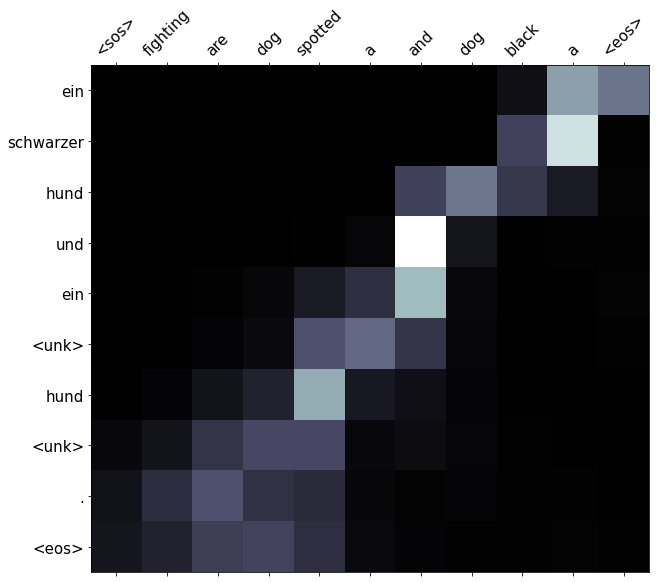

In [ ]:
display_attention(sentence, translation, attentions)